In [22]:
import numpy as np
import pandas as pd
import math
import itertools
import networkx as nx
import matplotlib.pyplot as plt
import osmnx as ox

In [23]:
df = pd.read_csv('/Users/ashwin/Desktop/150218623/150218623 cleaned.csv')
north, south, east, west = 12.933, 12.918, 77.630, 77.612
n = 100
filtered_df = df[(df['LAT'] >= south) & (df['LAT'] <= north) & (df['LONGITUDE'] >= west) & (df['LONGITUDE'] <= east)]
observations = np.array(list(zip(filtered_df['LAT'].head(n), filtered_df['LONGITUDE'].head(n))))
print(len(observations))

100


In [24]:
import osmnx as ox
north, south, east, west = 12.933, 12.918, 77.630, 77.612
G = ox.graph_from_bbox(north, south, east, west, network_type='all')
nodes = list(G.nodes(data=True))
states = np.array([(data['y'], data['x']) for _, data in nodes])
print(len(states))

/var/folders/g7/pjzz4q115nsb8sw2k_ff0dw80000gn/T/ipykernel_22329/1110440103.py:3: FutureWarning: The `north`, `south`, `east`, and `west` parameters are deprecated and will be removed in the v2.0.0 release. Use the `bbox` parameter instead.
  G = ox.graph_from_bbox(north, south, east, west, network_type='all')


727


In [25]:
import numpy as np
from math import exp, sqrt, pi

pairwise_distances = []
for i in range(len(observations) - 1):
    x1, y1 = observations[i]
    x2, y2 = observations[i + 1]
    distance = sqrt((x2 - x1)**2 + (y2 - y1)**2)
    pairwise_distances.append(distance)
TRANS = np.zeros((len(states), len(states), len(observations)-1))

beta = 0.95  

n = len(states)
for k in range(len(observations)-1):
    for i in range(n):
        for j in range(n):
            xtemp = np.linalg.norm(states[i] - states[j])
            dij = abs(xtemp - pairwise_distances[k])
            TRANS[i, j, k] = (1 / beta) * exp(-dij / beta)
        TRANS[i, :, k] = TRANS[i, :, k] / np.sum(TRANS[i, :, k])

sigztemp = []
for i in range(len(observations)):
    for j in range(len(states)):
        sigztemp.append(np.linalg.norm(observations[i] - states[j]))
sigz = 1.4 * np.median(sigztemp)

EMIS = np.zeros((len(states), len(observations)))
for i in range(len(observations)):
    for j in range(len(states)):
        EMIS[j, i] = (1 / (sqrt(2 * pi) * sigz)) * exp(-0.5 * ((np.linalg.norm(observations[i] - states[j])) / sigz) ** 2)

# seq = [1, 2, 3, 4]
seq = np.arange(1, len(observations)+1)

PRIOR = np.array([(1 / len(states))] * len(states))
# PRIOR[358] = 0.7

T = len(seq)  # Number of observations
n = EMIS.shape[0]  # Number of states

score = np.zeros((n, T))
pred = np.zeros((n, T))

for i in range(n):
    score[i, 0] = PRIOR[i] * EMIS[i, seq[0] - 1]

for t in range(1, T):
    for j in range(n):
        tscore = np.zeros(n)
        for k in range(n):
            tscore[k] = score[k, t - 1] * TRANS[k, j, t - 1] * EMIS[j, seq[t] - 1]
        score[j, t] = np.max(tscore)
        id = np.where(tscore == np.max(tscore))[0][0]
        pred[j, t] = id

IT = np.zeros(T, dtype=int)
IT[-1] = np.argmax(score[:, -1])

for t in range(T - 1, 0, -1):
    IT[t - 1] = int(pred[IT[t], t])

print(IT)

[411 141 162 521 521 675 591 534 216 367 429 251 257 225 165  68 595 356
 221 150 546 220 167 545 550 500 708 545 220 546 150 543 587 156 156 542
 390 404 392 445 262 159 233 154 104 418 102 103 724 415 237 155 686 413
 672 663 580 531 531 531 531 530 530 530 223 223 223 675 521 141 682 141
 521 521 521 521 521 675 403 496 164 251 217 225 169  68  59 548 150 546
 161 167 550 550 708 500 550 167 161 546]


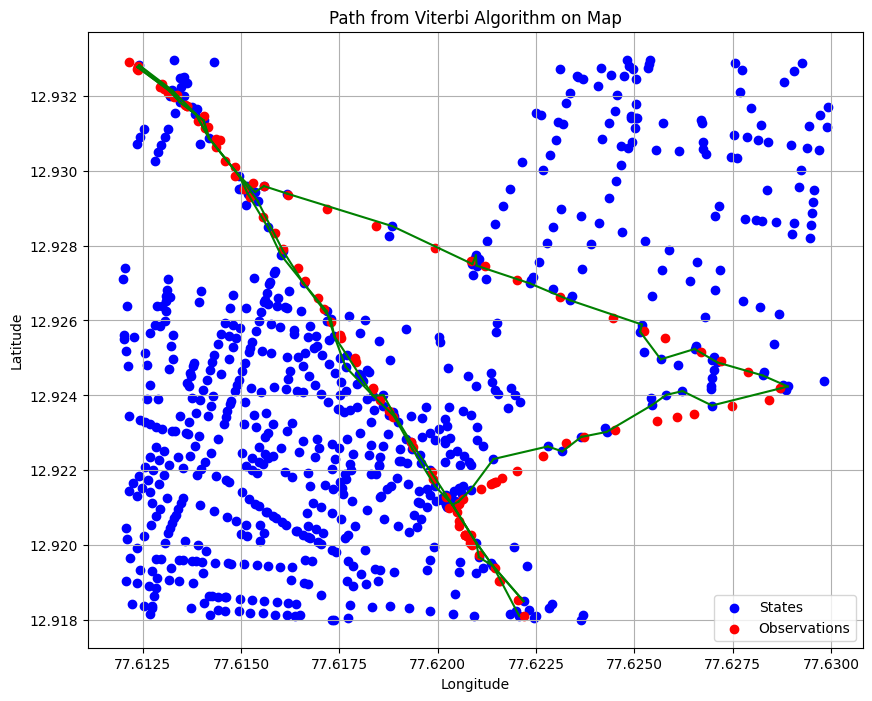

In [6]:
plt.figure(figsize=(10, 8))
plt.scatter(states[:, 1], states[:, 0], color='blue', label='States')
plt.scatter(observations[:, 1], observations[:, 0], color='red', label='Observations')
for i in range(len(IT) - 1 - 0):
    start_point = states[IT[i]]
    end_point = states[IT[i + 1]]
    plt.plot([start_point[1], end_point[1]], [start_point[0], end_point[0]], color='green')

plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.title('Path from Viterbi Algorithm on Map')
plt.legend()
plt.grid(True)
plt.show()

In [1]:
import networkx as nx
import matplotlib.pyplot as plt

def display_shortest_paths(paths, states):
    fig, ax = plt.subplots(figsize=(10, 8))  # Adjust figure size for better visualization
    for i, path in enumerate(paths):
        path_coordinates = [states[i] for i in path]
        x, y = zip(*path_coordinates)
        ax.plot(y, x, marker='o')  # Plot each path separately with a label

    plt.scatter(states[:, 1], states[:, 0], color='blue')
    plt.scatter(qt[:, 1], qt[:, 0], color='red')
    for i in range(len(IT) - 1):
        start_point = states[IT[i]]
        end_point = states[IT[i + 1]]
        ax.plot([start_point[1], end_point[1]], [start_point[0], end_point[0]], color='green')

    ax.set_aspect('equal')
    ax.set_xlabel('Longitude')
    ax.set_ylabel('Latitude')
    ax.set_title('Shortest Paths and Observations on Map')
    ax.legend()  # Show legend to differentiate between paths
    plt.grid(True)
    plt.show()

# Assuming `states` contains the coordinates of all states
# Modify the code to properly define `IT` and `states` variables if needed

# Assuming `IT`, `states`, and `qt` are defined properly
G = nx.Graph()
for i in range(len(IT) - 1):
    G.add_edge(IT[i], IT[i + 1])
shortest_paths = [nx.shortest_path(G, IT[i], IT[i + 1]) for i in range(len(IT) - 1)]

# Display the shortest paths along with states and observations
display_shortest_paths(shortest_paths, states)


NameError: name 'IT' is not defined